In [1]:
from dolfin import *
import numpy as np
import sys as sys
sys.path.append('../src/3D_to_1D/')
sys.path.append('../src/3D_to_1D/scripts/')
import pvs1D_utils as utils
import imp as imp
imp.reload(utils)

import pvs1D_utils as utils
from post_process import *

import seaborn as sns
sns.set()
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 2.0})

## Read meshes

In [2]:
# Read 1d mesh
mesh1D = Mesh()
case_path = '../src/C0092/'
results_path = '../results/results_B2/'
case_prefix = 'C0092_clip1_mesh1_0.95_ratio'
mesh1D_file = case_path + case_prefix + "_centerline_mesh.xdmf"
with XDMFFile(MPI.comm_world, mesh1D_file) as xdmf:
    xdmf.read(mesh1D)

# Read 1d coarse mesh
# (generated by make_coarse_1D_mesh.py)
mesh1D_c = Mesh()

mesh1D_file = results_path + "avg/XDMF/mesh1D_c_0.xdmf"
with XDMFFile(MPI.comm_world, mesh1D_file) as xdmf:
    xdmf.read(mesh1D_c)
    
# Shrink the geometry with a given constant
L_PVS = 44e-3 # [mm]
coord_factor = 2.0/L_PVS
    
mesh1D.coordinates()[:]/=coord_factor
# mesh1D_c does not have to be shrunk, as it was generated from mesh1D

# Read in radius
radius_hfile  = HDF5File(MPI.comm_world, case_path + case_prefix + "_HDF5/centerline_radius.h5", "r")
radius_a = Function(FunctionSpace(mesh1D, 'CG', 1))
radius_hfile.read(radius_a, "/function/vector_0")

radius_a.vector()[:]/=coord_factor #shrink

radius_a.vector()[:]*=0.5 # why is this needed?

radius_pv = project(2.95*radius_a, FunctionSpace(mesh1D, 'CG', 1))

mesh3D = Mesh()
mesh3D_file = case_path + case_prefix + "_PVS.xdmf"
with XDMFFile(MPI.comm_world, mesh3D_file) as xdmf:
    xdmf.read(mesh3D)
    
mesh3D.coordinates()[:]/=coord_factor

A_pv = project(3.14159*(radius_pv**2.0-radius_a**2.0), FunctionSpace(mesh1D, 'CG', 1))

## Read parameters

In [3]:
import json
import pandas as pd
param_f = open (results_path + 'params.json', "r")
params = json.load(param_f)
param_f.close()

## Read solutions

In [5]:
## Read in 1d solutions, 3d solutions and 3d averages ##

file_u = HDF5File(MPI.comm_world, results_path + '3D/HDF5/u.h5','r')
file_p = HDF5File(MPI.comm_world, results_path + '3D/HDF5/p.h5','r')

file_u_avg = HDF5File(MPI.comm_world, results_path + 'avg/HDF5/q_avg0.h5','r')
file_p_avg = HDF5File(MPI.comm_world, results_path + 'avg/HDF5/p_avg.h5','r')

file_p1D = HDF5File(MPI.comm_world, results_path + '1D/HDF5/p1D.h5','r')
file_q1D = HDF5File(MPI.comm_world, results_path + '1D/HDF5/q1D0.h5','r')

V1_c = FunctionSpace(mesh1D_c, 'CG', 1)

attr = file_u.attributes("/function")
nsteps = attr['count'] 

tang_comps = read_tangent(case_path, mesh1D, [])
correction_factor = compute_correction_factor(tang_comps, radius_a, radius_pv, mesh1D_c, mesh3D)

V1_c = FunctionSpace(mesh1D_c, 'CG', 1)

us, ps, u_avgs, p_avgs, q1Ds, p1Ds = [], [], [], [], [], []
for i in range(1, nsteps-2):
    name = "/function/vector_%d"%i

    u = Function(VectorFunctionSpace(mesh3D, "CG", 2))
    file_u.read(u, name)
    us.append(u)

    p = Function(FunctionSpace(mesh3D, "CG", 1))
    file_p.read(p, name)
    ps.append(p)
    
    p_avg = Function(FunctionSpace(mesh1D, "CG", 1))
    file_p_avg.read(p_avg, name)
    p_avgs.append(p_avg)
    
    u_avg = Function(FunctionSpace(mesh1D_c, "CG", 1))
    file_u_avg.read(u_avg, name)
    u_avgs.append(u_avg)

    # Read in 1D solutions at this time step
    q1D = Function(FunctionSpace(mesh1D, "CG", 2))
    file_q1D.read(q1D, name)
    
    p1D = Function(FunctionSpace(mesh1D, "CG", 1))
    file_p1D.read(p1D, name)
    
    # Add to solution lists
    q1Ds.append(q1D)
    p1Ds.append(p1D)
    
file_p_avg.close()
file_u_avg.close()

## Plot time dependent quantities

In [6]:
# We make a list of the solution at some fixed point x for different times

# For the points we use the cross-section centerpoints used in the paper
x_top = V1_c.tabulate_dof_coordinates()[60] # point at top cross section
x_bot = V1_c.tabulate_dof_coordinates()[len(mesh1D_c.coordinates())-60] # point at bottom cross section

q_avg_top = [q_avg(x_top) for q_avg in u_avgs]
p_avg_top = [p_avg(x_top) for p_avg in p_avgs]

q_avg_bot = [q_avg(x_bot) for q_avg in u_avgs]
p_avg_bot = [p_avg(x_bot) for p_avg in p_avgs]

q1D_top = [q1D(x_top) for q1D in q1Ds]
p1D_top = [p1D(x_top) for p1D in p1Ds]

q1D_bot = [q1D(x_bot) for q1D in q1Ds]
p1D_bot = [p1D(x_bot) for p1D in p1Ds]

In [7]:
p1Dmin = np.min([np.min(f.vector().get_local()) for f in p1Ds ])
p1Dmax = np.max([np.max(f.vector().get_local()) for f in p1Ds ])

q1Dmin = np.min([np.min(f.vector().get_local()) for f in q1Ds ])
q1Dmax = np.max([np.max(f.vector().get_local()) for f in q1Ds ])

p_avg_min = np.min([np.min(f.vector().get_local()) for f in p_avgs ])
p_avg_max = np.max([np.max(f.vector().get_local()) for f in p_avgs ])

q_avg_min = np.min([np.min(f.vector().get_local()) for f in u_avgs ])
q_avg_max = np.max([np.max(f.vector().get_local()) for f in u_avgs ])

print('p1D min: %1.3f max  %1.2e'%(p1Dmin, p1Dmax))
print('p avg min: %1.3f max  %1.2e'%(p_avg_min, p_avg_max))

print()
print('q avg min: %1.2e max  %1.2e'%(q_avg_min, q_avg_max))
print('q1D min: %1.2e max  %1.2e'%(q1Dmin, q1Dmax))

p1D min: -0.062 max  2.88e-01
p avg min: -0.050 max  2.59e-01

q avg min: -1.54e-03 max  1.95e-03
q1D min: -1.61e-03 max  2.23e-03


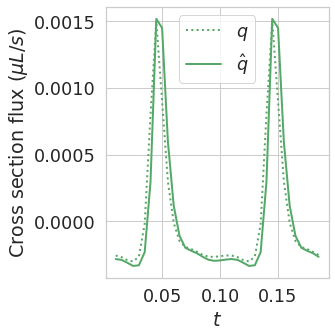

In [9]:
dt = params["dt"]

fig, ax = plt.subplots(figsize=(4, 5))

times = np.asarray(range(0, nsteps-2))*dt

plt.plot(times[2:], q_avg_bot[1:], 'g:', label='$q$')
plt.plot(times[2:], q1D_bot[0:-1], 'g-', label='$\hat{q}$')

ytick_vals = np.linspace(0, 0.001, 4)
ytick_labels = [f'{y:1.1e}' for y in ytick_vals]
ytick_labels = [label.replace('e-0', 'e-') for label in ytick_labels]
ytick_labels[2] = '0'

ax.set_xlabel('$t (s)$')
ax.set_ylabel('Cross section flux $(\\mu L/s)$')

#ax.set_yticks(ytick_vals)
#ax.set_yticklabels(ytick_labels)

ax.set_xlabel('$t$')

plt.legend()


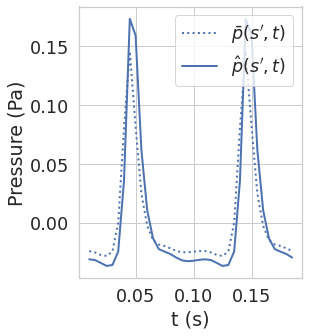

In [10]:
fig, ax = plt.subplots(figsize=(4, 5))

ax.set_xlabel('$t$')

ytick_vals = np.linspace(-0.05, 0.1, 4)
ytick_labels = [f'{y:1.2f}' for y in ytick_vals]
ytick_labels[1] = '0'

ax.plot(times[2:], p_avg_bot[1:], 'b:', label='$\\bar{p}(s\', t)$')
ax.plot(times[2:], p1D_bot[0:-1], 'b', label='$\hat{p}(s\',t)$')
ax.legend()

ax.set_ylabel('Pressure (Pa)')
ax.set_xlabel('t (s)')

#ax.set_yticks(ytick_vals)
#ax.set_yticklabels(ytick_labels)
